Ćwiczenia nr 2 - Ćwiczenia nr 2-3 - Techniki wyznaczania VaR (wg. książki J. Hulla)

Weźmy dane dot. dziennych stóp zwrotu dla wybranego waloru (niech te dane będą obejmowały okres od stycznia 2016 roku do końca września 2025 roku). 

Załóżmy, że będzie nas interesowało 500-dniowe okno danych historycznych. Celem pracy jest wyznaczenie ciągu wartości 99% VaR i 99% ES z wykorzystaniem 

metody historycznej, 
metody historycznej z wagami
Uwaga:

Punktem wyjścia jest definicja VaR (a właściwie jej związek z definicją kwantyla empirycznego rozkładu strat). 
To oznacza, że na podstawie danych historycznych (w ramach rozważanego horyzontu czasowego) należy zbudować empiryczny rozkład stóp zwrotu i wyznaczyć jego kwantyl (VaR). Wyznaczenie ES jest równie proste (definicja ES).
Dla metody historycznej można łatwo zdefiniować funkcję implementującą wartości VaR i ES w ramach okna estymacji, a później go przenieść po całym zestawie danych
Dla pozostałych metod trzeba odpowiedzieć sobie na pytanie - jak wyznaczyć empiryczny rozkład takich strat (tj. co tak naprawdę jest stratą (Xi) oraz ile wynosi prawdopodobieństwo poniesienia tej straty (pi) w ramach technik 2/3. Na pewno pomogą definicje z wykładu, ale też (w przypadku użycia pakietu R) polecam zapoznanie się z pakietem distr).


Zadanie dodatkowe:

Jeśli zadanie Ci się spodobało (ew. będziesz chciał mieć bogatszy projekt) możesz rozwiązać jeden (lub więcej) z trzech poniższych problemów.

(problem najłatwiejszy) Dobierz jeszcze 2-3 inne walory - chyba najlepiej powiązane z pierwszym (podobne waluty, podobne spółki giełdowe) - i spróbuj w ramach każdej metody wyznaczyć także owe indeksy ryzyka dla nich. Może uda Ci się zauważyć jakieś podobieństwa w wynikach?
(problem łatwy) Spróbuj wyznaczyć VaR i ES także metodą historyczną uwzględniającą informację o heteroskedastyczności stóp zwrotu, tj. EWMA lub model GARCH(1,1).
(problem łatwy) Na wykładzie mówiliśmy o metodzie Monte Carlo w wyznaczaniu VaR i ES. Załóż, że dane są opisane rozkładem normalnym (jego parametry wyznaczysz na podstawie próby) i spróbuj wykorzystując tę metodę wyznaczyć 99% VaR i 99% ES. Spróbuj odpowiedzieć na pytanie, jak się mają wielkości owego VaR/ES do VaR/ES wyznaczanego z wykorzystaniem np. metody historycznej z wagami. Czy te wnioski wydają się być naturalne?
(problem ciekawy) Dość dużą popularność ma wykorzystanie EVT (extreme value theory) do wyznaczania VAR. Jest to zrozumiałe, bo w dość prosty sposób, do tego umotywowany matematycznie, mogę dobrze definiować ogony rozkładu. Na podstawie fragmentu książki Hulla spróbuj zaimplementować to podejście (zbuduj odpowiednią funkcję). Jeśli Ci się uda, to porównaj te wyniki z innymi metodami. Możesz też dodatkowo sprawdzić działanie tej funkcji i funkcji, którą pewnie znajdziesz w R/Python.

In [48]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [49]:
CSV_PATH = Path('../data/spx_d.csv')

data_frame_daily: pd.DataFrame = pd.read_csv(
        CSV_PATH,
        # usecols=['datetime', 'open', 'high', 'low', 'close'],
        usecols=['Data','Otwarcie','Najwyzszy','Najnizszy','Zamkniecie','Wolumen'],
        parse_dates=['Data']
    )
data_frame_daily.set_index('Data').sort_index().astype('float64')  

# konwersja kolumny 'Data' na datetime, bo bez tego są błedne daty
data_frame_daily['Data'] = pd.to_datetime(data_frame_daily['Data'], errors='coerce')

# usuwam ewentualne błędne wiersze bez dat
data_frame_daily = data_frame_daily.dropna(subset=['Data'])

# indeks i sortuje
data_frame_daily = (
    data_frame_daily
    .set_index('Data')
    .sort_index()
    .astype('float64')
)
print(data_frame_daily.head(10))

            Otwarcie  Najwyzszy  Najnizszy  Zamkniecie       Wolumen
Data                                                                
2015-01-02   2058.90    2072.36    2046.04     2058.20  1.504833e+09
2015-01-05   2054.44    2054.44    2017.34     2020.58  2.110622e+09
2015-01-06   2022.15    2030.25    1992.44     2002.61  2.477839e+09
2015-01-07   2005.55    2029.61    2005.55     2025.90  2.114156e+09
2015-01-08   2030.61    2064.08    2030.61     2062.14  2.185561e+09
2015-01-09   2063.45    2064.43    2038.33     2044.81  1.868967e+09
2015-01-12   2046.13    2049.30    2022.58     2028.26  1.920256e+09
2015-01-13   2031.58    2056.93    2008.25     2023.03  2.281833e+09
2015-01-14   2018.40    2018.40    1988.44     2011.27  2.432600e+09
2015-01-15   2013.75    2021.35    1991.47     1992.67  2.375956e+09


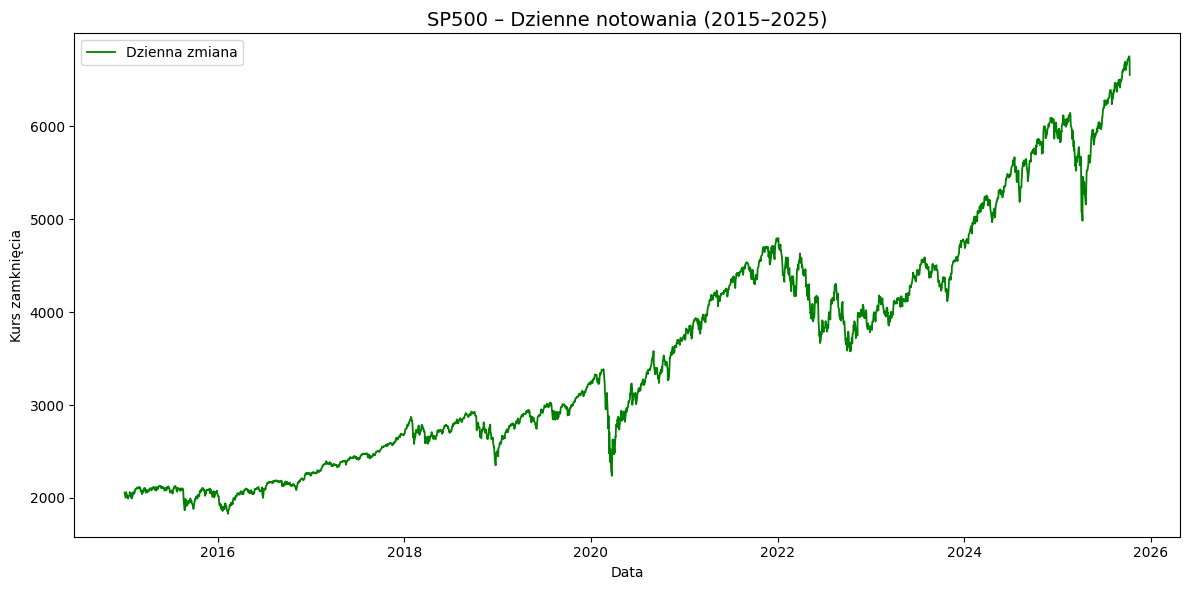

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    data_frame_daily.index,
    data_frame_daily['Zamkniecie'],
    label='Dzienna zmiana',
    color='green',
    linewidth=1.3
)

ax.set_title('SP500 – Dzienne notowania (2015–2025)', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('Kurs zamknięcia')
ax.legend()
plt.tight_layout()
plt.show()

Teraz wyznaczam logarytmiczne stopy zwrotu i tworzę funckje pomocnicze, żeby sprawdzić czy dane wyglądają sensownie.
Wykorzystuję do tego funkcje pomocnicze z poprzednich ćwiczeń z tą różnicą, iż zamiast zwracać zwroty w procentach, będę je zwracac
w ułamkach.

In [51]:
# Funkcja pomocznica do liczenia zwrotów
def compute_returns(series: pd.Series) -> pd.DataFrame:
    returns = pd.DataFrame(index=series.index)
    returns["simple_frac"] = (series - series.shift(1)) / series.shift(1)
    returns["log_frac"] = np.log(series / series.shift(1))
    return returns

# Funkcja pomocnicza do rysowania wykresów zwrotów
def plot_returns(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df["simple_frac"], label="Stopa prosta")
    ax.plot(df.index, df["log_frac"], label="Stopa logarytmiczna")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Data")
    ax.set_ylabel("Stopa zwrotu (%)")
    ax.legend()

    plt.tight_layout()
    plt.show()

            simple_frac  log_frac
Data                             
2025-09-29     0.002636  0.002632
2025-09-30     0.004091  0.004083
2025-10-01     0.003400  0.003394
2025-10-02     0.000618  0.000618
2025-10-03     0.000066  0.000066
2025-10-06     0.003647  0.003640
2025-10-07    -0.003811 -0.003819
2025-10-08     0.005828  0.005811
2025-10-09    -0.002756 -0.002759
2025-10-10    -0.027112 -0.027486


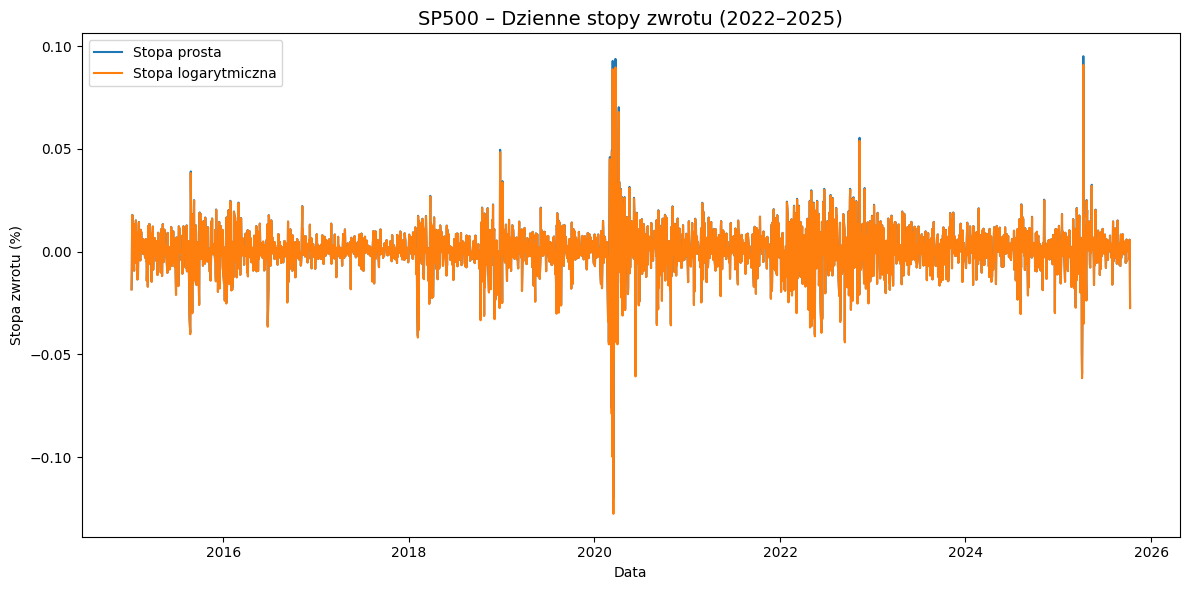

In [52]:
# DZIENNE
returns_daily = compute_returns(data_frame_daily["Zamkniecie"])
print(returns_daily.tail(10))
plot_returns(returns_daily, "SP500 – Dzienne stopy zwrotu (2022–2025)")

Teraz biorę się za właściwe liczenie VaR historycznego. Tak jak wcześńiej pisałem, wykorzytsam stopę logarytmiczną.

In [53]:
losses_daily = -returns_daily["log_frac"]
losses_daily = losses_daily.dropna()

In [54]:
WINDOW = 500 # ile dni bierzemy pod uwagę
QUANTILE_LEVEL = 0.99  # czyli 99% VaR
QUANTILE_LEVEL_PERCENTAHE = QUANTILE_LEVEL * 100

In [55]:
var_series = []

losses = losses_daily.values # przekształcenie, żeby łatwiej pracować na danych

for i in range(WINDOW, len(losses)):
    window_losses = losses[i-WINDOW:i]
    var_value = np.quantile(window_losses, QUANTILE_LEVEL)
    var_series.append(var_value)

# Konwersja spowrotem do serii pandas by mieć daty
var_index = losses_daily.index[WINDOW:]
var_series = pd.Series(var_series, index=var_index)
# print(var_series)

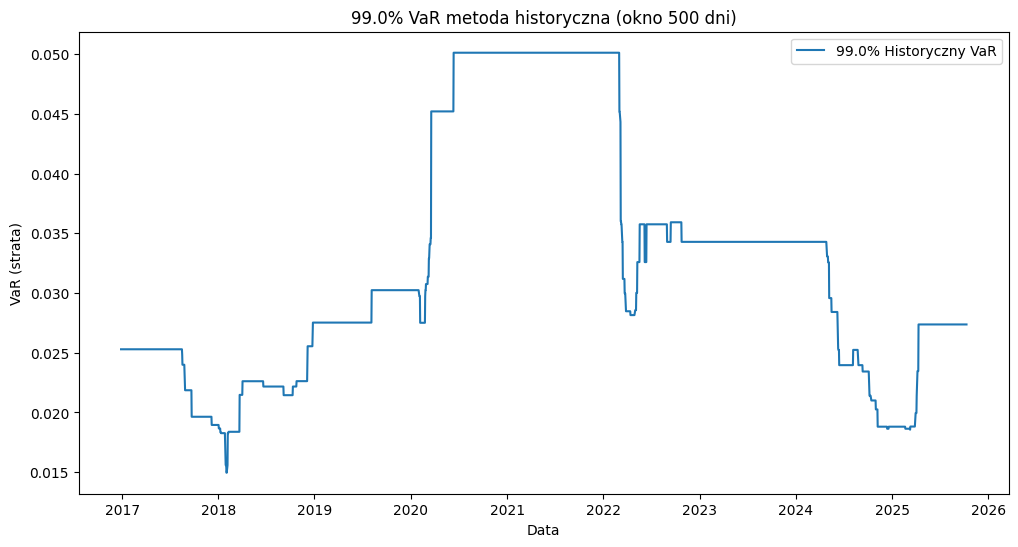

In [56]:
plt.figure(figsize=(12,6))
plt.plot(var_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% Historyczny VaR")
plt.title(f"{QUANTILE_LEVEL_PERCENTAHE}% VaR metoda historyczna (okno {WINDOW} dni)")
plt.xlabel("Data")
plt.ylabel("VaR (strata)")
plt.legend()
plt.show()


# ES - Expected Shortfall

In [57]:
es_series = []
var_series = []

for i in range(WINDOW, len(losses)):
    window_losses = losses[i-WINDOW:i]
    
    # VaR tak samo jak wcześniej
    var_value = np.quantile(window_losses, QUANTILE_LEVEL)
    var_series.append(var_value)

    # ES: średnia strata większa niż VaR
    es_value = window_losses[window_losses > var_value].mean()
    es_series.append(es_value)

var_series = pd.Series(var_series, index=losses_daily.index[WINDOW:])
es_series  = pd.Series(es_series, index=losses_daily.index[WINDOW:])


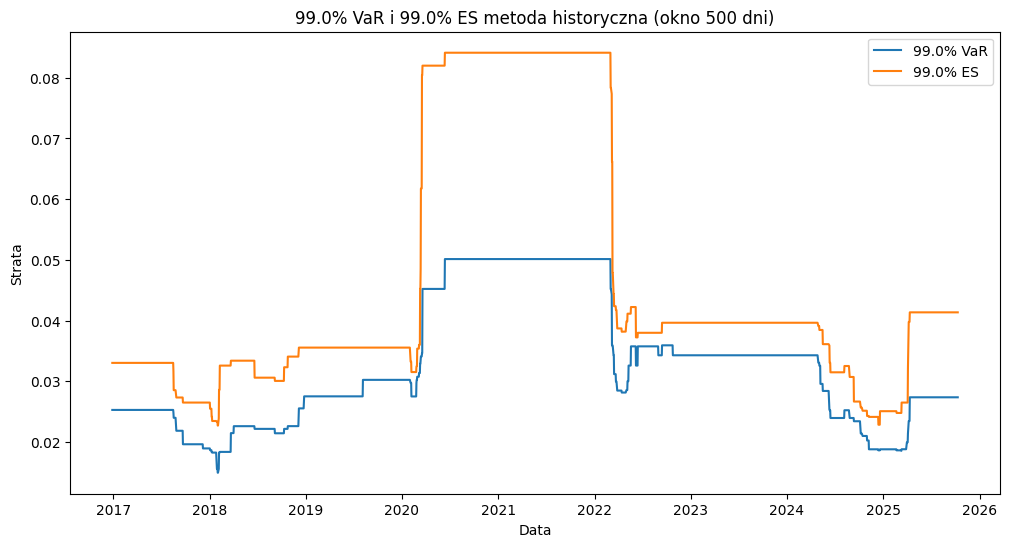

In [58]:
plt.figure(figsize=(12,6))
plt.plot(var_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% VaR")
plt.plot(es_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% ES")
plt.title(f"{QUANTILE_LEVEL_PERCENTAHE}% VaR i {QUANTILE_LEVEL_PERCENTAHE}% ES metoda historyczna (okno {WINDOW} dni)")
plt.xlabel("Data")
plt.ylabel("Strata")
plt.legend()
plt.show()


Otrzymany 99% VaR wskazuje maksymalną jednodniową stratę, która przy poziomie ufności 99% nie zostanie przekroczona.
Jednak VaR nie informuje o tym, jak duże mogą być straty w przypadku, gdy poziom ten zostanie przekroczony.
Dlatego obliczamy również Expected Shortfall (ES), czyli średnią stratę w najgorszym 1% dni.

ES jest zawsze większy niż VaR, ponieważ mierzy przeciętną wielkość strat katastrofalnych.
W okresach wysokiej zmienności (np. COVID-19) ES rośnie znacznie silniej niż VaR.

# Rozszerzenie nr 1 czyli dodanie wag

In [59]:
# STARA PIERWSZA WERSJA - NIE UŻYWANA JUŻ
# Funkcja pomocnicza: obliczanie wag p_i
def compute_weights(n, q=0.995):
    """
    Zwraca wektor wag p_i zgodnie ze wzorem z wykłądów
    i = 1...n (i=1 najstarsza obserwacja, i=n najnowsza)
    """
    i = np.arange(1, n+1)
    weights = (q**(n - i)) * (1 - q) / (1 - q**n)
    return weights
  
# Funkcje do VaR i ES liczonych w oknie czasu dla meotdy ważonej
def weighted_var_es(window_losses, q=0.995, alpha=0.99):
    n = len(window_losses)
    weights = compute_weights(n, q)
    
    # sortujemy straty
    sorted_idx = np.argsort(window_losses)
    sorted_losses = window_losses[sorted_idx]
    sorted_weights = weights[sorted_idx]
    
    # kumulacja prawdopodobieństw
    cumulative = np.cumsum(sorted_weights)
    # print(f"cumulative {cumulative}")
    
    # indeks VaR
    idx = np.searchsorted(cumulative, alpha)
    var_value = sorted_losses[idx]
    
    # ES = ważona średnia strat > VaR
    tail_losses = sorted_losses[idx:]
    tail_weights = sorted_weights[idx:]
    
    es_value = np.sum(tail_losses * tail_weights) / np.sum(tail_weights)
    
    return var_value, es_value
  
def weighted_var_es_strict(window_losses, q=0.995, alpha=0.95):
    """
    Liczy ważony VaR i ES w wersji strict (tak jak na prezentacji z wykładów).

    VaR:
      - sortujemy straty i wagi,
      - znajdujemy pierwszy punkt, gdzie suma wag >= alpha.

    Strict ES:
      - ES ma obejmować dokładnie (1 - alpha) prawdopodobieństwa,
      - dlatego zaczynamy od NAJGORSZYCH strat (końca rozkładu),
      - bierzemy ich wagi po kolei,
      - jeśli kolejna waga jest za duża to bierzemy tylko jej część "przycinamy",
      - kończymy, gdy łącznie zebraliśmy dokładnie (1 - alpha).

    W efekcie ES jest średnią najgorszych strat obejmującą precyzyjnie
    (1 - alpha) rozkładu to tak jak na slajdzie z przykładem 3% + 2% = 5%.
    """
    n = len(window_losses)
    weights = compute_weights(n, q)

    # Sortowanie rosnąco (od najlepszych do najgorszych)
    sorted_idx = np.argsort(window_losses)
    sorted_losses = window_losses[sorted_idx]
    sorted_weights = weights[sorted_idx]

    # Szukanie VaR
    cumulative = np.cumsum(sorted_weights)
    idx = np.searchsorted(cumulative, alpha)
    VaR = sorted_losses[idx]

    # Strict ES, zbieramy NAJGORSZE straty
    tail_needed = 1 - alpha
    tail_accum = 0.0
    ES_total = 0.0

    # iterujemy od NAJGORSZEJ (koniec listy) do góry
    for j in range(len(sorted_losses)-1, -1, -1):
        w = sorted_weights[j]
        x = sorted_losses[j]

        # jeśli cała waga się mieści to bierzemy całą
        if tail_accum + w <= tail_needed:
            ES_total += x * w
            tail_accum += w
        else:
            # przycinamy ostatnią wagę, żeby to 
            remaining = tail_needed - tail_accum
            ES_total += x * remaining
            tail_accum += remaining
            break

    ES = ES_total / tail_needed
    return VaR, ES

# Test
Żeby sprawdzić czy moja pomocnicza funkcja działa poprawnie, przetestuję to dla tych samych danych co na slajdzie z wykładu, a dokładniej slajd 58.
Wynik 4.599999999999997 czyli w zaokrągleniu poprawnie, mały bład z specyfiki działania liczb na komputerach.

In [60]:
losses_test = np.array([-5, 1, 10])
weights_test = np.array([0.90, 0.08, 0.02])

print(weighted_var_es_strict(losses_test, weights_test, alpha=0.95))

(np.int64(10), np.float64(10.0))


Data
2016-12-28    0.024828
2016-12-29    0.024828
2016-12-30    0.024828
2017-01-03    0.024828
2017-01-04    0.024828
Name: VaR_weighted, dtype: float64
Data
2016-12-28    0.031213
2016-12-29    0.031181
2016-12-30    0.031149
2017-01-03    0.031117
2017-01-04    0.031086
Name: ES_weighted, dtype: float64


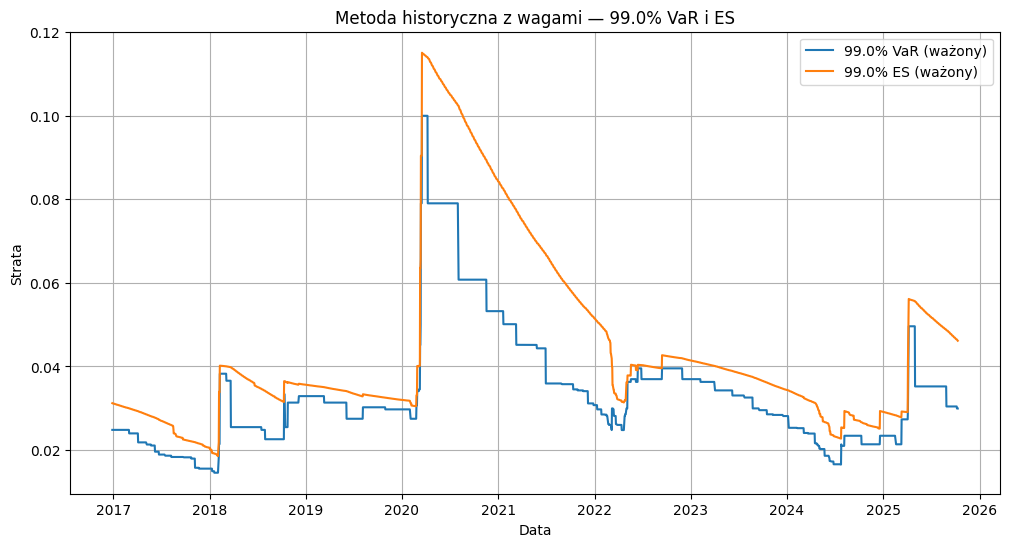

In [61]:
WINDOW = 500 # ile dni bierzemy pod uwagę
QUANTILE_LEVEL = 0.99  # czyli 99% VaR
QUANTILE_LEVEL_PERCENTAHE = QUANTILE_LEVEL * 100
Q_PARAMETER = 0.995

var_list = []
es_list = []

for i in range(WINDOW, len(losses)):
    window_losses = losses[i-WINDOW:i]
    # var_value, es_value = weighted_var_es(window_losses, q=Q_PARAMETER, alpha=QUANTILE_LEVEL)
    var_value, es_value = weighted_var_es_strict(window_losses, q=Q_PARAMETER, alpha=QUANTILE_LEVEL)
    var_list.append(var_value)
    es_list.append(es_value)

index_out = losses_daily.index[WINDOW:]
VaR_w = pd.Series(var_list, index=index_out, name="VaR_weighted")
ES_w = pd.Series(es_list, index=index_out, name="ES_weighted")

print(VaR_w.head())
print(ES_w.head())

# Wykres porównawczy
plt.figure(figsize=(12,6))
plt.plot(VaR_w, label=f"{QUANTILE_LEVEL_PERCENTAHE}% VaR (ważony)")
plt.plot(ES_w, label=f"{QUANTILE_LEVEL_PERCENTAHE}% ES (ważony)")
plt.title(f"Metoda historyczna z wagami — {QUANTILE_LEVEL_PERCENTAHE}% VaR i ES")
plt.xlabel("Data")
plt.ylabel("Strata")
plt.legend()
plt.grid(True)
plt.show()

# Wykres porównawczy obu metod

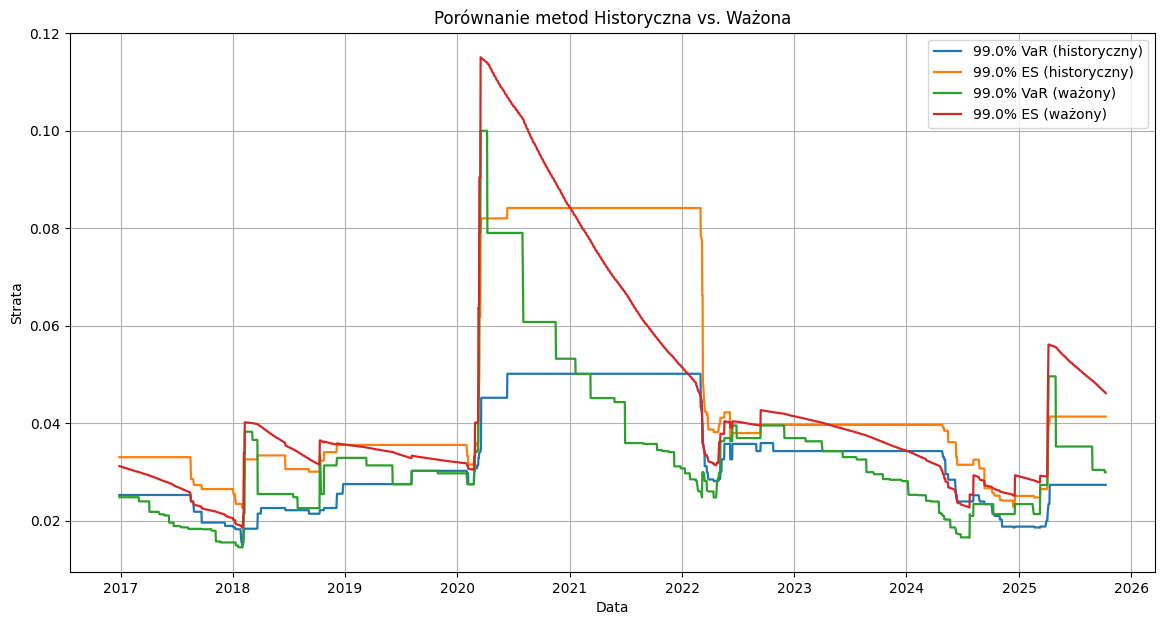

In [62]:
plt.figure(figsize=(14,7))

plt.plot(var_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% VaR (historyczny)", linewidth=1.6)
plt.plot(es_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% ES (historyczny)", linewidth=1.6)

plt.plot(VaR_w, label=f"{QUANTILE_LEVEL_PERCENTAHE}% VaR (ważony)", linewidth=1.6)
plt.plot(ES_w, label=f"{QUANTILE_LEVEL_PERCENTAHE}% ES (ważony)", linewidth=1.6)

plt.title(f"Porównanie metod Historyczna vs. Ważona")
plt.xlabel("Data")
plt.ylabel("Strata")
plt.legend()
plt.grid(True)
plt.show()


VaR ważony reaguje szybciej na nowe wydarzenia rynkowe, ponieważ nadajemy większe prawdopodobieństwo najnowszym obserwacjom.
ES ważony będzie zwykle wyższy (bardziej konserwatywny) niż ES historyczny, zwłaszcza w okresach podwyższonej zmienności.
Historyczny VaR/ES zmieniają się wolniej, bo traktują każdą obserwację jako jednakowo ważną.
W okresach takich jak 2020 (COVID) lub 2022 (inflacja/wojna) linie ważone także wzrastają szybcej.

# VaR i ES dla Bitcoina 2011-2025

In [63]:
CSV_PATH = Path('../data/BTCUSDT:MXD_1d_2010-01-01_2025-11-22.csv')

data_btcusdt_frame_daily: pd.DataFrame = pd.read_csv(
        CSV_PATH,
        usecols=['datetime', 'open', 'high', 'low', 'close'],
        # usecols=['Data','Otwarcie','Najwyzszy','Najnizszy','Zamkniecie','Wolumen'],
        parse_dates=['datetime']
    )
data_btcusdt_frame_daily.set_index('datetime').sort_index().astype('float64')  

# konwersja kolumny 'Data' na datetime, bo bez tego są błedne daty
data_btcusdt_frame_daily['datetime'] = pd.to_datetime(data_btcusdt_frame_daily['datetime'], errors='coerce')

# usuwam ewentualne błędne wiersze bez dat
data_btcusdt_frame_daily = data_btcusdt_frame_daily.dropna(subset=['datetime'])

# indeks i sortuje
data_btcusdt_frame_daily = (
    data_btcusdt_frame_daily
    .set_index('datetime')
    .sort_index()
    .astype('float64')
)
print(data_btcusdt_frame_daily.head(10))

               open     high      low    close
datetime                                      
2011-01-01  0.30000  0.30000  0.30000  0.30000
2011-01-02  0.29997  0.29997  0.29997  0.29997
2011-01-03  0.29500  0.29500  0.29500  0.29500
2011-01-04  0.29895  0.29895  0.29895  0.29895
2011-01-05  0.29900  0.29900  0.29900  0.29900
2011-01-06  0.29800  0.29800  0.29800  0.29800
2011-01-07  0.32000  0.32000  0.32000  0.32000
2011-01-08  0.32290  0.32290  0.32290  0.32290
2011-01-09  0.32300  0.32300  0.32300  0.32300
2011-01-10  0.32659  0.32659  0.32659  0.32659


            simple_frac  log_frac
datetime                         
2025-11-12    -0.013629 -0.013723
2025-11-13    -0.019304 -0.019493
2025-11-14    -0.051138 -0.052492
2025-11-15     0.010595  0.010539
2025-11-16    -0.013963 -0.014061
2025-11-17    -0.021709 -0.021948
2025-11-18     0.008086  0.008054
2025-11-19    -0.015123 -0.015239
2025-11-20    -0.053713 -0.055210
2025-11-21    -0.017404 -0.017557


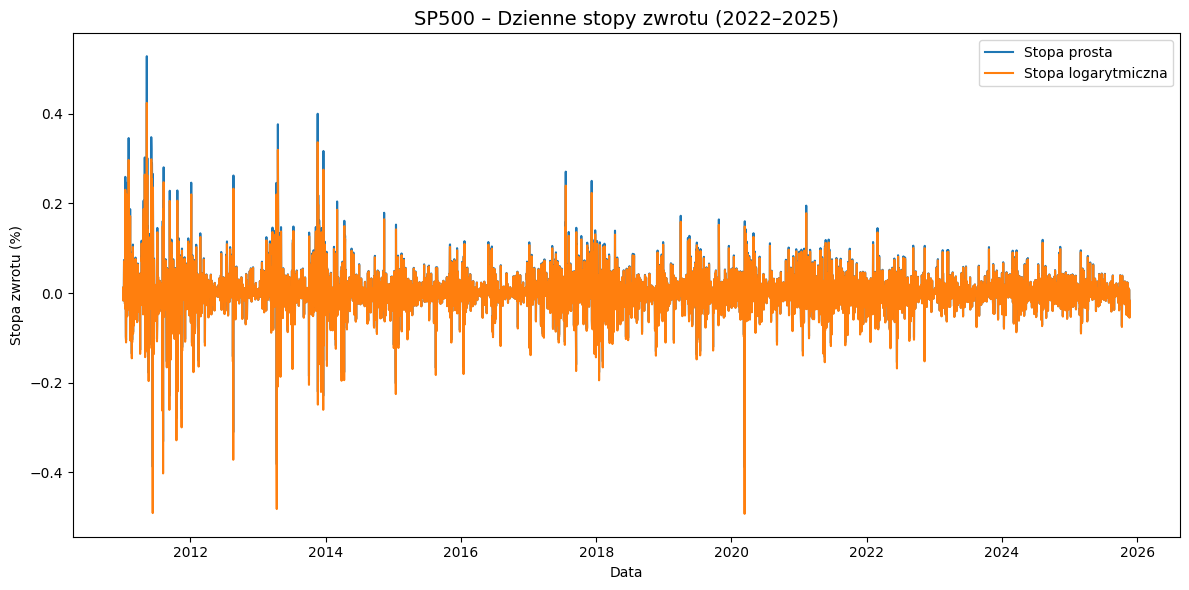

datetime
2012-05-16    0.219601
2012-05-17    0.219601
2012-05-18    0.219601
2012-05-19    0.219601
2012-05-20    0.219601
Name: VaR_weighted, dtype: float64
datetime
2012-05-16    0.321132
2012-05-17    0.320624
2012-05-18    0.320119
2012-05-19    0.319617
2012-05-20    0.319117
Name: ES_weighted, dtype: float64


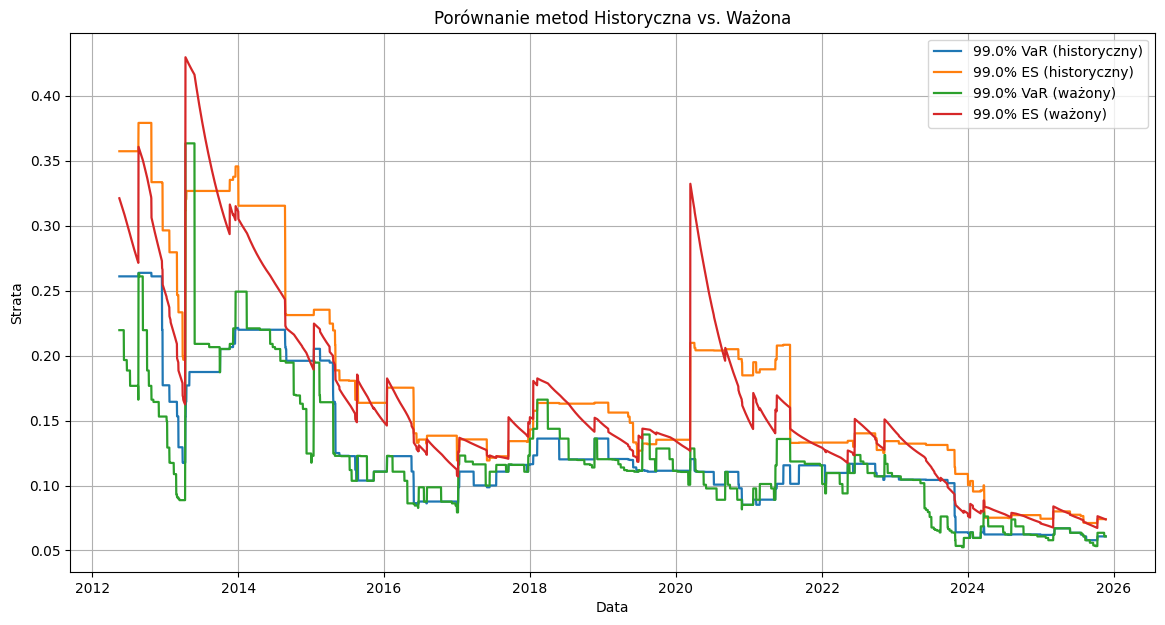

In [67]:
# DZIENNE
returns_daily_btcusd = compute_returns(data_btcusdt_frame_daily["close"])
print(returns_daily_btcusd.tail(10))
plot_returns(returns_daily_btcusd, "SP500 – Dzienne stopy zwrotu (2022–2025)")

losses_daily = -returns_daily_btcusd["log_frac"]
losses_daily = losses_daily.dropna()

WINDOW = 500 # ile dni bierzemy pod uwagę
QUANTILE_LEVEL = 0.99  # czyli 99% VaR
QUANTILE_LEVEL_PERCENTAHE = QUANTILE_LEVEL * 100

var_series = []

losses = losses_daily.values # przekształcenie, żeby łatwiej pracować na danych

for i in range(WINDOW, len(losses)):
    window_losses = losses[i-WINDOW:i]
    var_value = np.quantile(window_losses, QUANTILE_LEVEL)
    var_series.append(var_value)

# Konwersja spowrotem do serii pandas by mieć daty
var_index = losses_daily.index[WINDOW:]
var_series = pd.Series(var_series, index=var_index)
# print(var_series)

es_series = []
var_series = []

for i in range(WINDOW, len(losses)):
    window_losses = losses[i-WINDOW:i]
    
    # VaR tak samo jak wcześniej
    var_value = np.quantile(window_losses, QUANTILE_LEVEL)
    var_series.append(var_value)

    # ES: średnia strata większa niż VaR
    es_value = window_losses[window_losses > var_value].mean()
    es_series.append(es_value)

var_series = pd.Series(var_series, index=losses_daily.index[WINDOW:])
es_series  = pd.Series(es_series, index=losses_daily.index[WINDOW:])

WINDOW = 500 # ile dni bierzemy pod uwagę
QUANTILE_LEVEL = 0.99  # czyli 99% VaR
QUANTILE_LEVEL_PERCENTAHE = QUANTILE_LEVEL * 100
Q_PARAMETER = 0.995

var_list = []
es_list = []

for i in range(WINDOW, len(losses)):
    window_losses = losses[i-WINDOW:i]
    # var_value, es_value = weighted_var_es(window_losses, q=Q_PARAMETER, alpha=QUANTILE_LEVEL)
    var_value, es_value = weighted_var_es_strict(window_losses, q=Q_PARAMETER, alpha=QUANTILE_LEVEL)
    var_list.append(var_value)
    es_list.append(es_value)

index_out = losses_daily.index[WINDOW:]
VaR_w = pd.Series(var_list, index=index_out, name="VaR_weighted")
ES_w = pd.Series(es_list, index=index_out, name="ES_weighted")

print(VaR_w.head())
print(ES_w.head())

# # Wykres porównawczy
# plt.figure(figsize=(12,6))
# plt.plot(VaR_w, label=f"{QUANTILE_LEVEL_PERCENTAHE}% VaR (ważony)")
# plt.plot(ES_w, label=f"{QUANTILE_LEVEL_PERCENTAHE}% ES (ważony)")
# plt.title(f"Metoda historyczna z wagami — {QUANTILE_LEVEL_PERCENTAHE}% VaR i ES")
# plt.xlabel("Data")
# plt.ylabel("Strata")
# plt.legend()
# plt.grid(True)
# plt.show()
plt.figure(figsize=(14,7))

plt.plot(var_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% VaR (historyczny)", linewidth=1.6)
plt.plot(es_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% ES (historyczny)", linewidth=1.6)

plt.plot(VaR_w, label=f"{QUANTILE_LEVEL_PERCENTAHE}% VaR (ważony)", linewidth=1.6)
plt.plot(ES_w, label=f"{QUANTILE_LEVEL_PERCENTAHE}% ES (ważony)", linewidth=1.6)

plt.title(f"Porównanie metod Historyczna vs. Ważona")
plt.xlabel("Data")
plt.ylabel("Strata")
plt.legend()
plt.grid(True)
plt.show()

# GARCH(1,1)

**Niedokończone, wykres wydaje mi się na odwrót, czyli COVID-19 crash pokazuje, że strata maleje a po niej strata rośnie. A wedłu mojej intuicji powinno być na owrót. Tak więc była to próba z wykorztsaniem gotowej biblioteki**
DLATEGO PROSZĘ NA DALSZY KOD NIE ZWRACAĆ UWAGI

In [ ]:
from arch import arch_model
from scipy.stats import norm
import matplotlib.pyplot as plt

returns = returns_daily["log_frac"].dropna()

# Estymacja modelu GARCH(1,1)
model = arch_model(returns, vol='GARCH', p=1, q=1, mean='constant', dist='normal')
res = model.fit(update_freq=10)
print(res.summary())

sigma_series = res.conditional_volatility
sigma_series.name = "sigma"

# VaR 99%
alpha = 0.99
z = norm.ppf(1 - alpha)
VaR_garch = sigma_series * abs(z)

# ES 99%
ES_garch = sigma_series * (norm.pdf(z) / (1 - alpha))


Iteration:     10,   Func. Count:    130,   Neg. LLF: -3947.3700904570874
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6547.874993428692
            Iterations: 15
            Function evaluations: 135
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               log_frac   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6547.87
Distribution:                  Normal   AIC:                          -13087.7
Method:            Maximum Likelihood   BIC:                          -13064.1
                                        No. Observations:                 2709
Date:                Sun, Nov 23 2025   Df Residuals:                     2708
Time:                        13:57:30   Df Model:                            1
    

/Users/anteqkois/venvs/myenv/lib/python3.12/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


Początkowe wartości zmienności generowane przez model GARCH(1,1) są niestabilne z uwagi na brak wcześniejszych obserwacji.
Po ok. 20–30 dniach model osiąga stan stacjonarny i od tego momentu prognozy zmienności oraz VaR/ES są stabilne.
Dlatego na wykresie usuwam 30 początkowych dni, by wykres był bardziej czytelny

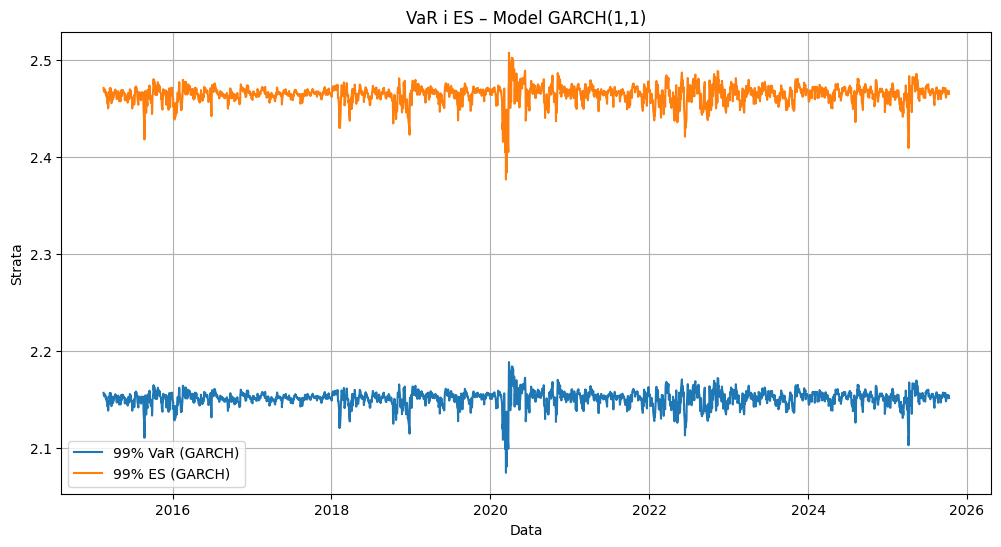

In [66]:
plt.figure(figsize=(12,6))
plt.plot(VaR_garch.iloc[30:], label="99% VaR (GARCH)")
plt.plot(ES_garch.iloc[30:], label="99% ES (GARCH)")
plt.title("VaR i ES – Model GARCH(1,1)")
plt.xlabel("Data")
plt.ylabel("Strata")
plt.legend()
plt.grid(True)
plt.show()